In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as req
from io import StringIO

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split

# Dataset Construction for Regressor

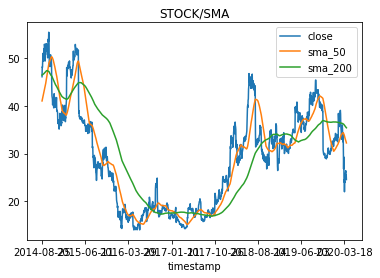

In [35]:
function = "TIME_SERIES_DAILY"
symbol = "TWTR"
api_key = "<API-KEY-HERE>"
datatype = "csv"
size = "full"

url = "https://www.alphavantage.co/query?function=" + function + "&symbol=" + symbol + "&apikey=" + api_key + "&datatype=" + datatype + "&outputsize=" + size

csv_name = "Exports/" + symbol + ".csv"

try:
    df = pd.read_csv(csv_name, index_col = 0)
except FileNotFoundError:
    r = req.get(url)
    buffer = StringIO(r.text)
    df = pd.read_csv(buffer, sep=",", index_col = 0)
    
    #Reverse the dataframe, since it starts from today and goes through the past years
    df = df.iloc[::-1]
    
    #Add the prevision column (this will be our target for the regression)
    df['prevision'] = df['close'].shift(-1)
    
    #Calculate the simple moving averages
    df['sma_50'] = df['close'].rolling(50).mean()
    df['sma_200'] = df['close'].rolling(200).mean()
    
    #Drop the rows with NaN values (basic dataset cleaning)
    df = df.dropna()
    
    df.to_csv(csv_name)
finally:
    pd.DataFrame({
        'close': df.close,
        'sma_50': df.sma_50,
        'sma_200': df.sma_200
    }).plot(title="STOCK/SMA")

# Dataset Contruction for Classifier
We start by getting the "convenient" sections of the chart

In [3]:
df_class = pd.Series()
section = pd.Series()

for index, row in df.iterrows():
    if row.sma_200 > row.sma_50:
            section[index] = row
    else:
        if len(section) > 0:
            df_class[index] = section
            section = pd.Series()

Then we get our 100% value and assign the different percentages based on it

In [15]:
dataset = pd.DataFrame()

for index, section in df_class.items():
    min_close = section[0]['close']
    
    #Get the minimum close price
    for item in section:
        if item['close'] < min_close:
            min_close = item['close']
    
    #Assign a percentage based on the minimum price
    for item in section:
        percentage = (min_close / item['close']) * 100
        if percentage < 70:
            label = "BAD"
        elif percentage < 80:
            label = "GOOD"
        elif percentage < 90:
            label = "VERY GOOD"
        elif percentage <= 100:
            label = "EXCELLENT"
        
        item['label'] = label 
        dataset = dataset.append(pd.Series(item))

dataset.drop(columns=['prevision', 'percentage']).to_csv(symbol + "_train.csv")

# Regressor in action

In [36]:
X = np.array(df.drop(['prevision'], 1))
Y = np.array(df['prevision'])
X = preprocessing.scale(X)

#Test on the last 5 days
X_prediction = X[-5:]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [42]:
#We can now perform a linear regression on our data
reg = LinearRegression()
reg.fit(X_train, Y_train)
prevision = reg.predict(X_prediction)

for i in range(-5, 0):
    print("Real: " + str(df['close'][i]), "Predicted: " + str(prevision[i]))

Real: 25.97 Predicted: 25.8225843197508
Real: 26.41 Predicted: 26.28930014614234
Real: 25.29 Predicted: 25.17570106835879
Real: 25.59 Predicted: 25.370087844276817
Real: 24.56 Predicted: 24.706140473091924
